In [21]:
import torch
import torch.nn as nn
import numpy as np
import torchmetrics
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from functools import partial

torch.manual_seed(42)
DefaultConv2d = partial(nn.Conv2d, kernel_size = 3, padding = "same")
model = nn.Sequential(
    DefaultConv2d(in_channels=1, out_channels=64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    DefaultConv2d(in_channels=64, out_channels=128), nn.ReLU(),
    DefaultConv2d(in_channels=128, out_channels=128), nn.ReLU(), 
    nn.MaxPool2d(kernel_size=2),
    DefaultConv2d(in_channels=128, out_channels=256), nn.ReLU(),
    DefaultConv2d(in_channels=256, out_channels=256), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(in_features=2304, out_features=128), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=128, out_features=64), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=64, out_features=10)
).to(device)

In [4]:
def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)
    return metric.compute()

In [18]:
def train(model, optimizer, loss_fn, metric, train_loader, valid_loader, n_epochs):
    history = {"train_losses": [],
               "train_metric": [],
               "valid_metric": []}
    
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)

        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metric"].append(metric.compute().item())
        history["valid_metric"].append(evaluate_tm(model, valid_loader, metric).item())
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metric'][-1]:.4f}, "
              f"valid metric: {history['valid_metric'][-1]:.4f}")
    return history


In [7]:
import torchvision
import torchvision.transforms.v2 as T

toTensor = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)])
train_valid_data = torchvision.datasets.FashionMNIST(
    root="dataset", train=True, transform=toTensor, download=True
)
test_data = torchvision.datasets.FashionMNIST(
    root="dataset", train=False, transform=toTensor, download=True
)

torch.manual_seed(42)
train_data, valid_data = torch.utils.data.random_split(
    train_valid_data, [55_000, 5_000]
)


100%|██████████| 26.4M/26.4M [00:23<00:00, 1.12MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 168kB/s]
100%|██████████| 4.42M/4.42M [00:04<00:00, 920kB/s] 
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.20MB/s]


In [36]:
class_names = train_valid_data.classes

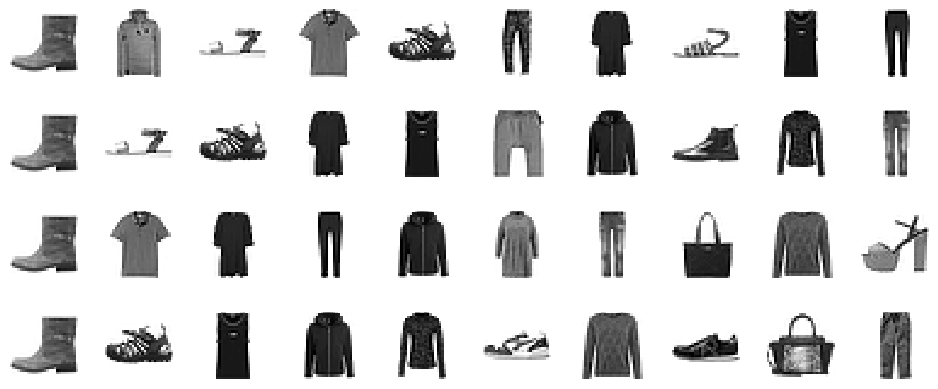

In [ ]:
n_rows = 4
plt.figure(figsize=(12, n_rows * 1.2))
for row in range(n_rows):
    for class_index in range(10):
        X_img = train_data[class_index * row + class_index][0][0]
        y_img = train_data[class_index * row + class_index][1]
        plt.subplot(4, 10, 10 * row + class_index + 1)
        plt.imshow(X_img, cmap="binary", interpolation="nearest")
        plt.axis("off")

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [15]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=128)
test_loader = DataLoader(test_data, batch_size=128)

In [19]:
optimizer = torch.optim.NAdam(model.parameters(), lr = 2e-3)
metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 50
history = train(model, optimizer, loss_fn, metric,train_loader, valid_loader, n_epochs)

Epoch 1/50, train loss: 0.4821, train metric: 0.8295, valid metric: 0.8630
Epoch 2/50, train loss: 0.3803, train metric: 0.8712, valid metric: 0.8916
Epoch 3/50, train loss: 0.3346, train metric: 0.8873, valid metric: 0.8974
Epoch 4/50, train loss: 0.2997, train metric: 0.8990, valid metric: 0.9050
Epoch 5/50, train loss: 0.2817, train metric: 0.9056, valid metric: 0.9096
Epoch 6/50, train loss: 0.2607, train metric: 0.9121, valid metric: 0.9154
Epoch 7/50, train loss: 0.2433, train metric: 0.9194, valid metric: 0.9090
Epoch 8/50, train loss: 0.2342, train metric: 0.9200, valid metric: 0.9138
Epoch 9/50, train loss: 0.2197, train metric: 0.9260, valid metric: 0.9132
Epoch 10/50, train loss: 0.2057, train metric: 0.9300, valid metric: 0.9150
Epoch 11/50, train loss: 0.2019, train metric: 0.9319, valid metric: 0.9182
Epoch 12/50, train loss: 0.1920, train metric: 0.9347, valid metric: 0.9244
Epoch 13/50, train loss: 0.1843, train metric: 0.9379, valid metric: 0.9234
Epoch 14/50, train lo

In [20]:
test_acc = evaluate_tm(model, test_loader, metric)
test_acc

tensor(0.9182, device='cuda:0')